## Assignment

## Requirements:

### Data Cleaning:
 - Correct OCR-like errors in account numbers and descriptions.
 - Normalize amount values to a consistent format, handling currency symbols and negative values for withdrawals.
### Data Analysis:
 - Identify and separate individual transactions from aggregated data (subtotals/yearly totals).
 - Reconcile transactions by ensuring the consistency of aggregated data with individual transactions.
### Anomaly Detection:
 - Detect and flag any unusual transactions that could indicate errors or fraudulent activity based on criteria such as unusually high transaction amounts.
### Reporting:
 - Generate a report summarizing the findings from your analysis, including any discrepancies in reconciliation and a list of detected anomalies.
### Documentation:
 - Provide a README file detailing how to run your script, an overview of your approach to data cleaning, analysis, and anomaly detection, and how to interpret the output of your script.


In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('banking_data_assignment.csv')

In [137]:
# check the first five rows
data.head()

,Transaction Date,Account Number,Transaction Type,Amount,Description
0,2023-04-25,ACClOO7,Online Transfer,3708,Utilities
1,2023-12-03,ACClOO4,ATM Withdrawal,$3825,Online Purchase
2,2023-03-08,ACClOO3,Deposit,-160,Rent
3,2023-03-06,ACClOO7,Online Transfer,$4551,Groceries
4,2023-06-07,ACClOO3,Online Transfer,$-4605,Rent


In [138]:
data['Transaction Type'].value_counts()

Card Payment       28
Deposit            25
Withdrawal         25
Online Transfer    25
Direct Debit       24
ATM Withdrawal     23
Name: Transaction Type, dtype: int64

In [139]:
# Check the shape of the dataframe
data.shape

(163, 5)

In [140]:
#check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction Date  163 non-null    object
 1   Account Number    163 non-null    object
 2   Transaction Type  150 non-null    object
 3   Amount            163 non-null    object
 4   Description       150 non-null    object
dtypes: object(5)
memory usage: 6.5+ KB


In [141]:
# check null entries
data.isnull().sum()

Transaction Date     0
Account Number       0
Transaction Type    13
Amount               0
Description         13
dtype: int64

In [142]:
data[data.isnull().any(axis=1)]

,Transaction Date,Account Number,Transaction Type,Amount,Description
8,2023-07-28,SUBTOTAL,NaN,-59.0,NaN
21,2023-05-28,SUBTOTAL,NaN,-16045.0,NaN
26,2023-03-28,SUBTOTAL,NaN,3283.0,NaN
57,2023-12-31,YEARLY TOTAL,NaN,-62124.0,NaN
71,2023-12-28,SUBTOTAL,NaN,-6214.0,NaN
79,2023-10-28,SUBTOTAL,NaN,4345.0,NaN
81,2023-02-28,SUBTOTAL,NaN,-6399.0,NaN
93,2023-04-28,SUBTOTAL,NaN,1584.0,NaN
98,2023-09-28,SUBTOTAL,NaN,-17563.0,NaN
132,2023-06-28,SUBTOTAL,NaN,-534.0,NaN


In [143]:
data.dtypes

Transaction Date    object
Account Number      object
Transaction Type    object
Amount              object
Description         object
dtype: object

## DATA CLEANING

### 1. OCR errors
### 2. Amount - handling currency symbols and negative values for withdrawals.

In [144]:
#There are no OCR errors in this column
data['Description'].value_counts()

Rent               32
Online Purchase    27
Transfer           25
Groceries          23
Salary             23
Utilities          20
Name: Description, dtype: int64

In [145]:
# aggregate is labelled as "SUBTOTAL"
data['Account Number'].value_counts()

# 1 has been scanned as l
# 0 has been scanned as o

ACClOO2         19
ACClOO9         18
ACClOO4         18
ACClOO7         16
ACClOOl         15
ACClOOO         15
ACClOO3         14
ACClOO6         14
SUBTOTAL        12
ACClOO5         12
ACClOO8          9
YEARLY TOTAL     1
Name: Account Number, dtype: int64

In [146]:
def data_clean(df):
    data['Account Number'] = data['Account Number'].apply(str)
    
    # correcting string errors
    error_dict = {'l':'1', 'o':'0'}    
    df['Account Number'] = df['Account Number'].apply(lambda x: ''.join([error_dict.get(c, c) for c in x]))
    
    # Normalizing 'Amount'
    df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)
    
    # coverting to date field
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
    return df

data_clean(data)

,Transaction Date,Account Number,Transaction Type,Amount,Description
0,2023-04-25,ACC1OO7,Online Transfer,3708.0,Utilities
1,2023-12-03,ACC1OO4,ATM Withdrawal,3825.0,Online Purchase
2,2023-03-08,ACC1OO3,Deposit,-160.0,Rent
3,2023-03-06,ACC1OO7,Online Transfer,4551.0,Groceries
4,2023-06-07,ACC1OO3,Online Transfer,-4605.0,Rent
...,...,...,...,...,...
158,2023-09-27,ACC1OO2,Card Payment,4071.0,Rent
159,2023-11-02,ACC1OO9,Card Payment,-3680.0,Groceries
160,2023-10-27,ACC1OO7,Online Transfer,-636.0,Rent
161,2023-09-10,ACC1OOO,Card Payment,-1112.0,Online Purchase


## Data Analysis:
### 1. Identify and separate individual transactions from aggregated data (subtotals/yearly totals).
### 2. Reconcile transactions by ensuring the consistency of aggregated data with individual transactions.


In [147]:
def analyse(data):
    # Separate individual transactions from monthly and yearly aggregates
    individual = data[(data['Account Number'] != 'SUBTOTAL') & (data['Account Number'] != 'YEARLY TOTAL')]
    aggregate_monthly = data[data['Account Number'] == 'SUBTOTAL']
    aggregate_yearly = data[data['Account Number'] == 'YEARLY TOTAL']
    
    # Group by 'Transaction Date' and calculate the sum of all montlhy transactions for individual transactions
    monthly_grouped_sum = individual.groupby(individual['Transaction Date'].dt.to_period("M"))['Amount'].sum().reset_index()
    monthly_grouped_sum['Transaction Date'] = monthly_grouped_sum['Transaction Date'].astype(str)
    
    # check if monthly subtotal is correct
    aggregate_monthly['Transaction Date'] = aggregate_monthly['Transaction Date'].dt.to_period("M").astype(str)
    
    merged = monthly_grouped_sum.merge(aggregate_monthly, on='Transaction Date', suffixes=('_indiv', '_subtotal'))
    merged['Difference'] = merged['Amount_indiv'] - merged['Amount_subtotal']
    
    return merged

analyse(data)


,Transaction Date,Amount_indiv,Account Number,Transaction Type,Amount_subtotal,Description,Difference
0,2023-01,-15729.0,SUBTOTAL,NaN,-15729.0,NaN,0.0
1,2023-02,-6399.0,SUBTOTAL,NaN,-6399.0,NaN,0.0
2,2023-03,3283.0,SUBTOTAL,NaN,3283.0,NaN,0.0
3,2023-04,1584.0,SUBTOTAL,NaN,1584.0,NaN,0.0
4,2023-05,-16045.0,SUBTOTAL,NaN,-16045.0,NaN,0.0
5,2023-06,-534.0,SUBTOTAL,NaN,-534.0,NaN,0.0
6,2023-07,-59.0,SUBTOTAL,NaN,-59.0,NaN,0.0
7,2023-08,-5849.0,SUBTOTAL,NaN,-5849.0,NaN,0.0
8,2023-09,-17563.0,SUBTOTAL,NaN,-17563.0,NaN,0.0
9,2023-10,4345.0,SUBTOTAL,NaN,4345.0,NaN,0.0


### As we can see, the difference is 0, hence the aggregated data for month is accurate

## Anomaly Detection:
- Detect and flag any unusual transactions that could indicate errors or fraudulent activity based on criteria such as unusually high transaction amounts.


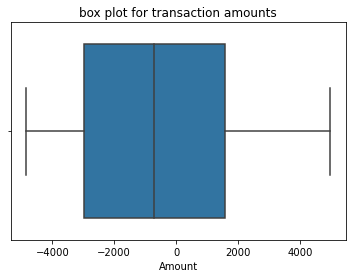

In [148]:
# check for outliers in Amount
individual = data[(data['Account Number'] != 'SUBTOTAL') & (data['Account Number'] != 'YEARLY TOTAL')]
sns.boxplot(individual['Amount'])
plt.title('box plot for transaction amounts')
plt.show()

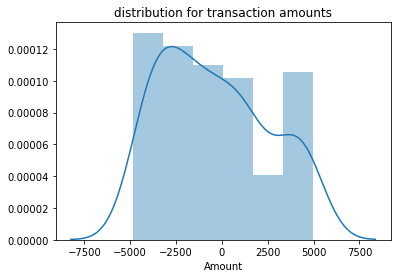

In [149]:
individual = data[(data['Account Number'] != 'SUBTOTAL') & (data['Account Number'] != 'YEARLY TOTAL')]
sns.distplot(individual['Amount'])
plt.title('distribution for transaction amounts')
plt.show()

In [150]:
## detect outliers

def detect_outliers(data):
    individual = data[(data['Account Number'] != 'SUBTOTAL') & (data['Account Number'] != 'YEARLY TOTAL')]
    # Calculate the first (Q1) and third (Q3) quartiles
    Q1 = individual['Amount'].quantile(0.25)
    Q3 = individual['Amount'].quantile(0.75)
    IQR = Q3 - Q1

    # Define the boundaries for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # show outliers
    outliers = individual[(individual['Amount'] < lower_bound) | (individual['Amount'] > upper_bound)]
    return outliers

detect_outliers(data)

## There are no outliers in current scenario

,Transaction Date,Account Number,Transaction Type,Amount,Description


In [155]:


class ProcessData:
    def __init__(self, data):
        self.data = data

    def data_clean(self):
        # Normalize account numbers to strings and correct common errors
        error_dict = {'l': '1', 'o': '0'}
        self.data['Account Number'] = self.data['Account Number'].astype(str).apply(lambda x: ''.join(error_dict.get(c, c) for c in x))

        # Convert 'Amount' from string to float, removing '$' and ',' characters
        self.data['Amount'] = self.data['Amount'].replace('[\$,]', '', regex=True).astype(float)

        # Convert 'Transaction Date' to datetime
        self.data['Transaction Date'] = pd.to_datetime(self.data['Transaction Date'])

    def analyse(self):
        # Filter individual transactions and aggregate entries
        individual = self.data[(self.data['Account Number'] != 'SUBTOTAL') & (self.data['Account Number'] != 'YEARLY TOTAL')]
        aggregate_monthly = self.data[self.data['Account Number'] == 'SUBTOTAL']
        aggregate_yearly = self.data[self.data['Account Number'] == 'YEARLY TOTAL']

        # Sum monthly transactions
        monthly_grouped_sum = individual.groupby(individual['Transaction Date'].dt.to_period("M"))['Amount'].sum().reset_index(name='Amount_sum')
        monthly_grouped_sum['Transaction Date'] = monthly_grouped_sum['Transaction Date'].astype(str)

        # Merge with aggregate monthly data
        aggregate_monthly['Transaction Date'] = aggregate_monthly['Transaction Date'].dt.to_period("M").astype(str)
        merged = monthly_grouped_sum.merge(aggregate_monthly, left_on='Transaction Date', right_on='Transaction Date', suffixes=('_indiv', '_subtotal'))
        merged['Difference'] = merged['Amount_sum'] - merged['Amount_subtotal']

        return merged

    def detect_outliers(self):
        individual = data[(data['Account Number'] != 'SUBTOTAL') & (data['Account Number'] != 'YEARLY TOTAL')]
        # Calculate the first (Q1) and third (Q3) quartiles
        Q1 = individual['Amount'].quantile(0.25)
        Q3 = individual['Amount'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the boundaries for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # show outliers
        outliers = individual[(individual['Amount'] < lower_bound) | (individual['Amount'] > upper_bound)]
        return outliers


Report
1. Data Cleaning Summary:
   - Corrected OCR-like errors in account numbers. Descriptions columns did not have OCR errors.
   - Normalized amount values across transactions, handling currency symbols and negative values.

2. Data Analysis Summary:
   - Separated individual transactions from aggregated data.
   - Found no discrepancies in transaction reconciliation.

3. Anomaly Detection Summary:
   - There were no unusual transactions based on amount criteria.
